In [1]:
import pandas as pd
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import IPython.display as display
from matplotlib import animation
import torch
from torch.utils.data import DataLoader
import copy
from torch import nn
%matplotlib inline
import matplotlib.pyplot as plt
import random
from scipy import stats as st
from dnaDataloader import expermentDataloader
from dnaDataloader import addData
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

# Single-molecule experiment prediction model

This notebook is the step by step development process for making a SNN to predict the reactivity level and number of reactions in Single-molecule experiments
Data is provided via the Kent State University chemistry department. The model development is provided by the Kent State University computer science department

<table style="border:none;padding: 10px;margin: auto;">
    <tr style="border:none;padding: 10px;margin: auto;">
<td style="border:none;padding: 10px;margin: auto;">
    <b>Contacts from the chem dept.</b><br>
            Li Zuo <br>
            Email: lzuo4@kent.edu <br>
            Office: 303B Willems Hall (ISB) <br>
            <br>
            Dr. Hao Shen<br>
            Email: hshen7@kent.edu<br>
        </td>
        <td style="border:none;padding: 10px;margin: auto;">
            <b>Contacts from the CS dept.</b><br>
    Kendric Hood<br>
            Email: khood5@kent.edu<br>
            Office: 160 Math and Science Building (MSB)<br>
            <br>
            Dr. Qiang Guan <br>
            Email: qguan@kent.edu<br>
        </td>
    </tr>
</table>

Working with data from <code>Prepocessing/data/</code> should have folder for each experment setup (in terms of disctance of magnent in mm). Each folder should have a list of events and their frame numbers as excel file. Events are recorded as events per 0.05 secs. The raw excel files are converted to CSV files with preprocess.py.

The processed file are shorted versions of the orignal files, i.e. its only the first X secs. These csv files have a 1 or a 0 for each 0.05 sec inteval. 1 means event 0 menas no event.  The index file has the list of each processed file path and the target (total number of events) they are in. 

- ran for 20 mins ~ 12000 frames
<table>
    <tr>
        <td> folder </td><td>total number of files</td>
    </tr>
    <tr>
        <td> 1.5mm_35.14pN </td><td>27</td>
    </tr>
    <tr>
        <td> 2mm_22.6pN </td><td>29</td>
    </tr>
    <tr>
        <td> 3mm_9.24pN </td><td>16</td>
    </tr>
    <tr>
        <td> 5mm_1.46pN </td><td>63</td>
    </tr>
    <tr>
        <td> 9mm_0.002pN </td><td>21</td>
    </tr>
</table>
 Total number of examples <em>156</em>

In [2]:
datasetlow = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low", 
)
datasetmedium = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium", 
)
datasetHigh = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high", 
)

print(f"datasetlow:{len(datasetlow)}")
print(f"datasetmedium:{len(datasetmedium)}")
print(f"datasetHigh:{len(datasetHigh)}")
print(f"Total: {len(datasetlow) + len(datasetmedium) + len(datasetHigh)}")

datasetlow:56
datasetmedium:16
datasetHigh:84
Total: 156


In [3]:
highTargets = [i[1][0] for i in datasetHigh]
mediumTargets = [i[1][0] for i in datasetmedium]
lowTargets = [i[1][0] for i in datasetlow]
highTargets

[339,
 296,
 303,
 283,
 337,
 301,
 305,
 342,
 310,
 321,
 321,
 298,
 392,
 328,
 379,
 340,
 340,
 285,
 274,
 285,
 282,
 105,
 51,
 297,
 191,
 352,
 238,
 80,
 303,
 167,
 103,
 107,
 184,
 379,
 55,
 89,
 484,
 535,
 262,
 113,
 501,
 196,
 179,
 488,
 165,
 327,
 710,
 135,
 87,
 167,
 133,
 258,
 635,
 224,
 53,
 538,
 462,
 311,
 187,
 219,
 57,
 34,
 165,
 446,
 175,
 219,
 363,
 243,
 375,
 413,
 210,
 155,
 342,
 252,
 55,
 234,
 336,
 248,
 90,
 93,
 228,
 61,
 280,
 456]

In [4]:
def averageDiff(data: list):
    diffs = []
    while data:
        point = data.pop()
        for i in data:
            diffs.append(abs(point - i))
    return np.sum(diffs)/len(diffs)

In [5]:
def printStats(data: list):
    print("+------------------")
    print(f"| total number of experments: {len(data)}")
    print(f"| min: {np.min(data)}")
    print(f"| max: {np.max(data)}")
    print(f"| average: {np.average(data)}")
    print(f"| median: {np.median(data)}")
    print(f"| mode: {st.mode(data, keepdims=False)}")
    print(f"| average difference: {averageDiff(data)}")
    print("+------------------")

High
+------------------
| total number of experments: 84
| min: 34
| max: 710
| average: 265.01190476190476
| median: 277.0
| mode: ModeResult(mode=55, count=2)
| average difference: 156.210843373494
+------------------
Medium
+------------------
| total number of experments: 16
| min: 20
| max: 172
| average: 107.25
| median: 127.0
| mode: ModeResult(mode=132, count=2)
| average difference: 55.6
+------------------
Low
+------------------
| total number of experments: 56
| min: 13
| max: 93
| average: 35.42857142857143
| median: 30.5
| mode: ModeResult(mode=29, count=4)
| average difference: 16.967532467532468
+------------------


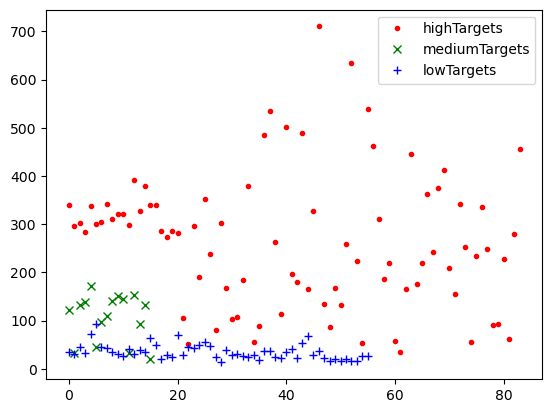

In [6]:
plt.plot(list(range(len(highTargets))), highTargets, '.', color='red', label="highTargets")
plt.plot(list(range(len(mediumTargets))), mediumTargets, 'x', color='green', label="mediumTargets")
plt.plot(list(range(len(lowTargets))), lowTargets, '+', color='blue', label="lowTargets")
plt.legend(numpoints=1)
print("High")
printStats(highTargets)
print("Medium")
printStats(mediumTargets)
print("Low")
printStats(lowTargets)

## Working with new data

- ran for 1 hour ~ 72000 frames
<table>
    <tr>
        <td> folder </td><td>total number of files</td>
    </tr>
    <tr>
        <td> 50_nM_AR </td><td>640</td>
    </tr>
    <tr>
        <td> 100_nM_AR </td><td>499</td>
    </tr>
    <tr>
        <td> 400_nM_AR </td><td>477</td>
    </tr>
    <tr>
        <td> 800_nM_AR </td><td>564</td>
    </tr>
    <tr>
        <td> 1200_nM_AR </td><td>794</td>
    </tr>
    <tr>
        <td> 1800_nM_AR </td><td>888</td>
    </tr>
</table>
 Total number of examples <em>3862</em>

In [7]:
datasetLarge = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/allData/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/allData/", 
)
print(f"datasetLarge:{len(datasetLarge)}")

datasetLarge:3862


Large Dataset
+------------------
| total number of experments: 3862
| min: 35
| max: 382
| average: 83.42050750906266
| median: 68.0
| mode: ModeResult(mode=51, count=83)
| average difference: 45.66128694559559
+------------------


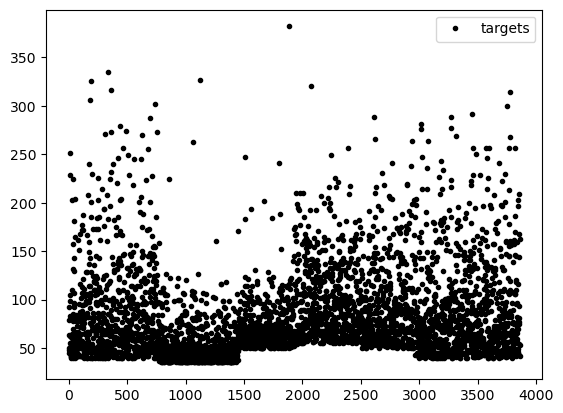

In [8]:
targets = [i[1][0] for i in datasetLarge]
plt.plot(list(range(len(targets))), targets, '.', color='black', label="targets")
plt.legend(numpoints=1)
print("Large Dataset")
printStats(targets)

In [11]:
len(datasetLarge[0][0])

12000